# Registration 101

Image registration is a critical tool in longitudinal monitoring:

- Estimation of local changes
- Comparison to same animal (less variance)
- [3R's](https://www.nc3rs.org.uk/the-3rs)




## Goal of tutorial:
- Introduce the concept of aligning images
- Demonstrate the use of numerical comparison between images
- Introduce concept of optimisation
- Registering images within framework (Thesis: Matthias Grass & Nicholas Ohs)

## setting up a responsive enviroment

In [1]:
# Please do not edit this code, it is important for choosing a compatible rendered for images

# libraries for viewing images
import sys
sys.path.append('reg101_files')
from image_viewing import horizontal_pane, overlay_RGB, overlay_RGB_cost
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# numpy as always
import numpy as np

In [2]:
# this is a way of finding the fastest image display on your platform
print("Using:", matplotlib.get_backend())
gui_env = ['WXAgg', 'TKAgg', 'QT5Agg', 'GTKAgg', 'Qt4Agg']
for gui in gui_env:
    try:
        print("testing", gui)
        matplotlib.use(gui, warn=False, force=True)
        from matplotlib import pyplot as plt
        break
    except:
        continue
print("Using:", matplotlib.get_backend())

Using: module://ipykernel.pylab.backend_inline
testing WXAgg
Using: WXAgg


## What does registration actually do?

In the example bellow there are images from 2 weeks.

The position of the animal in the scanner was different each.


<IPython.core.display.Javascript object>


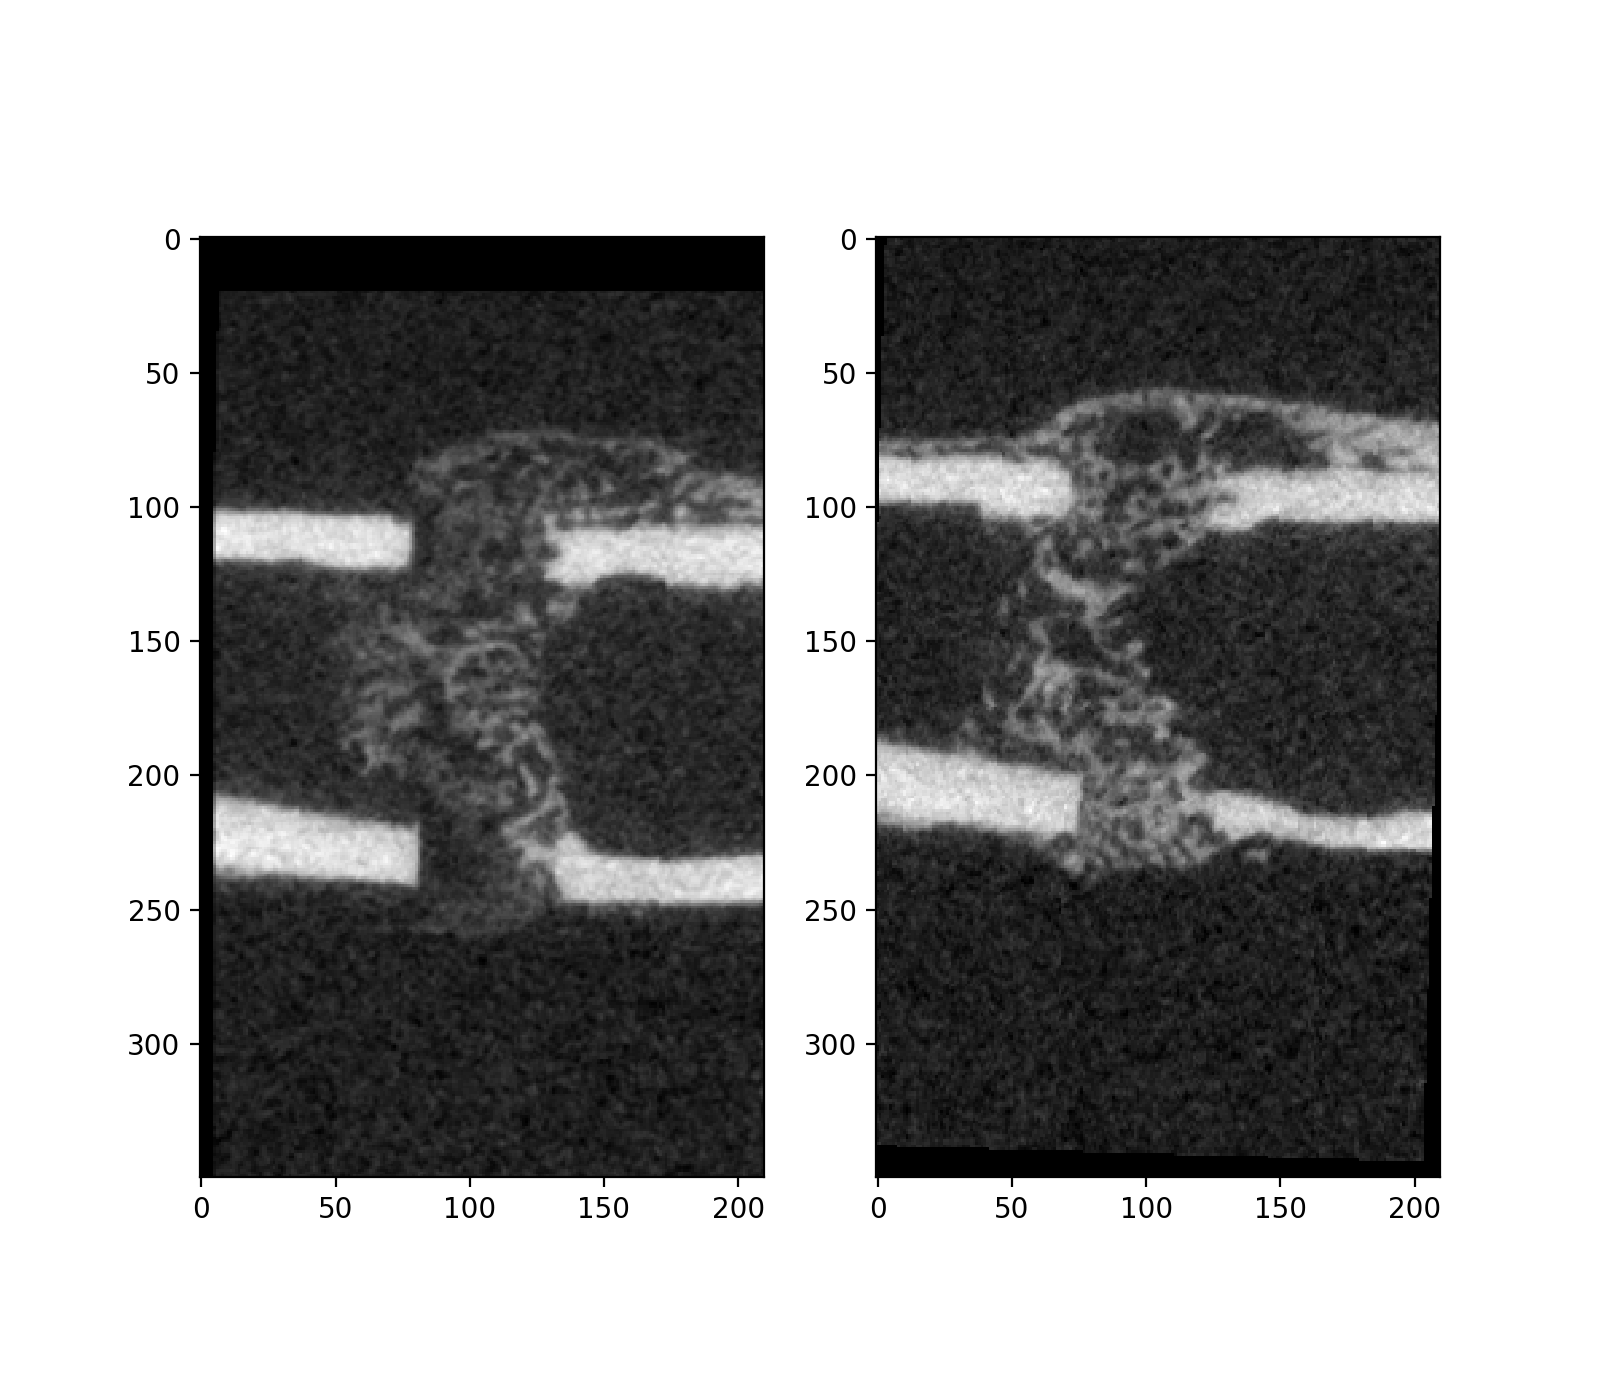

In [3]:
%matplotlib notebook
# this allows the image to be viewed in the notebook with edge
matplotlib.rcParams['figure.figsize'] = (8, 7)

images = [mpimg.imread('reg101_files/week2.tiff'), mpimg.imread('reg101_files/week3.tiff')]

horizontal_pane(images)  # shows images side by side

How can we interpret these images?

In in vivo studies, it is still common to *dynamic histomorphometry*, where markers are given to the mice at different intervals over the course if a study. These are built into the bone matrix and afterwards can be labeled and visualised in histological sections.

![alt text](osteoid.jpg)

In the above image above the green strain was used to mark the surface where bone formed. While the red is marking Osteoid (newly formed un minerlaised bone). The method is limited to purely observation of anabolic events. Resorption of bone removes material and therefore there is nothing which can be stained.

Inspired by these histological images we can create a virtual histology image. In these images we will "stain" the change of mineralisation between the two weeks. Both images are grey-scale (1 -color) , we can emulate the histology by using colour channels. Here we put the *Later* week in *green* and the *Former* week in *red*, both weeks are averaged in the blue channel.

When the images are aligned we see white (R+G+B) when the *Former* week is brighter we see *green* and when the  *later* week is brighter we see *red*. This is essentially formation == green and resorption == red. The function bellow does this for use automically.


<IPython.core.display.Javascript object>


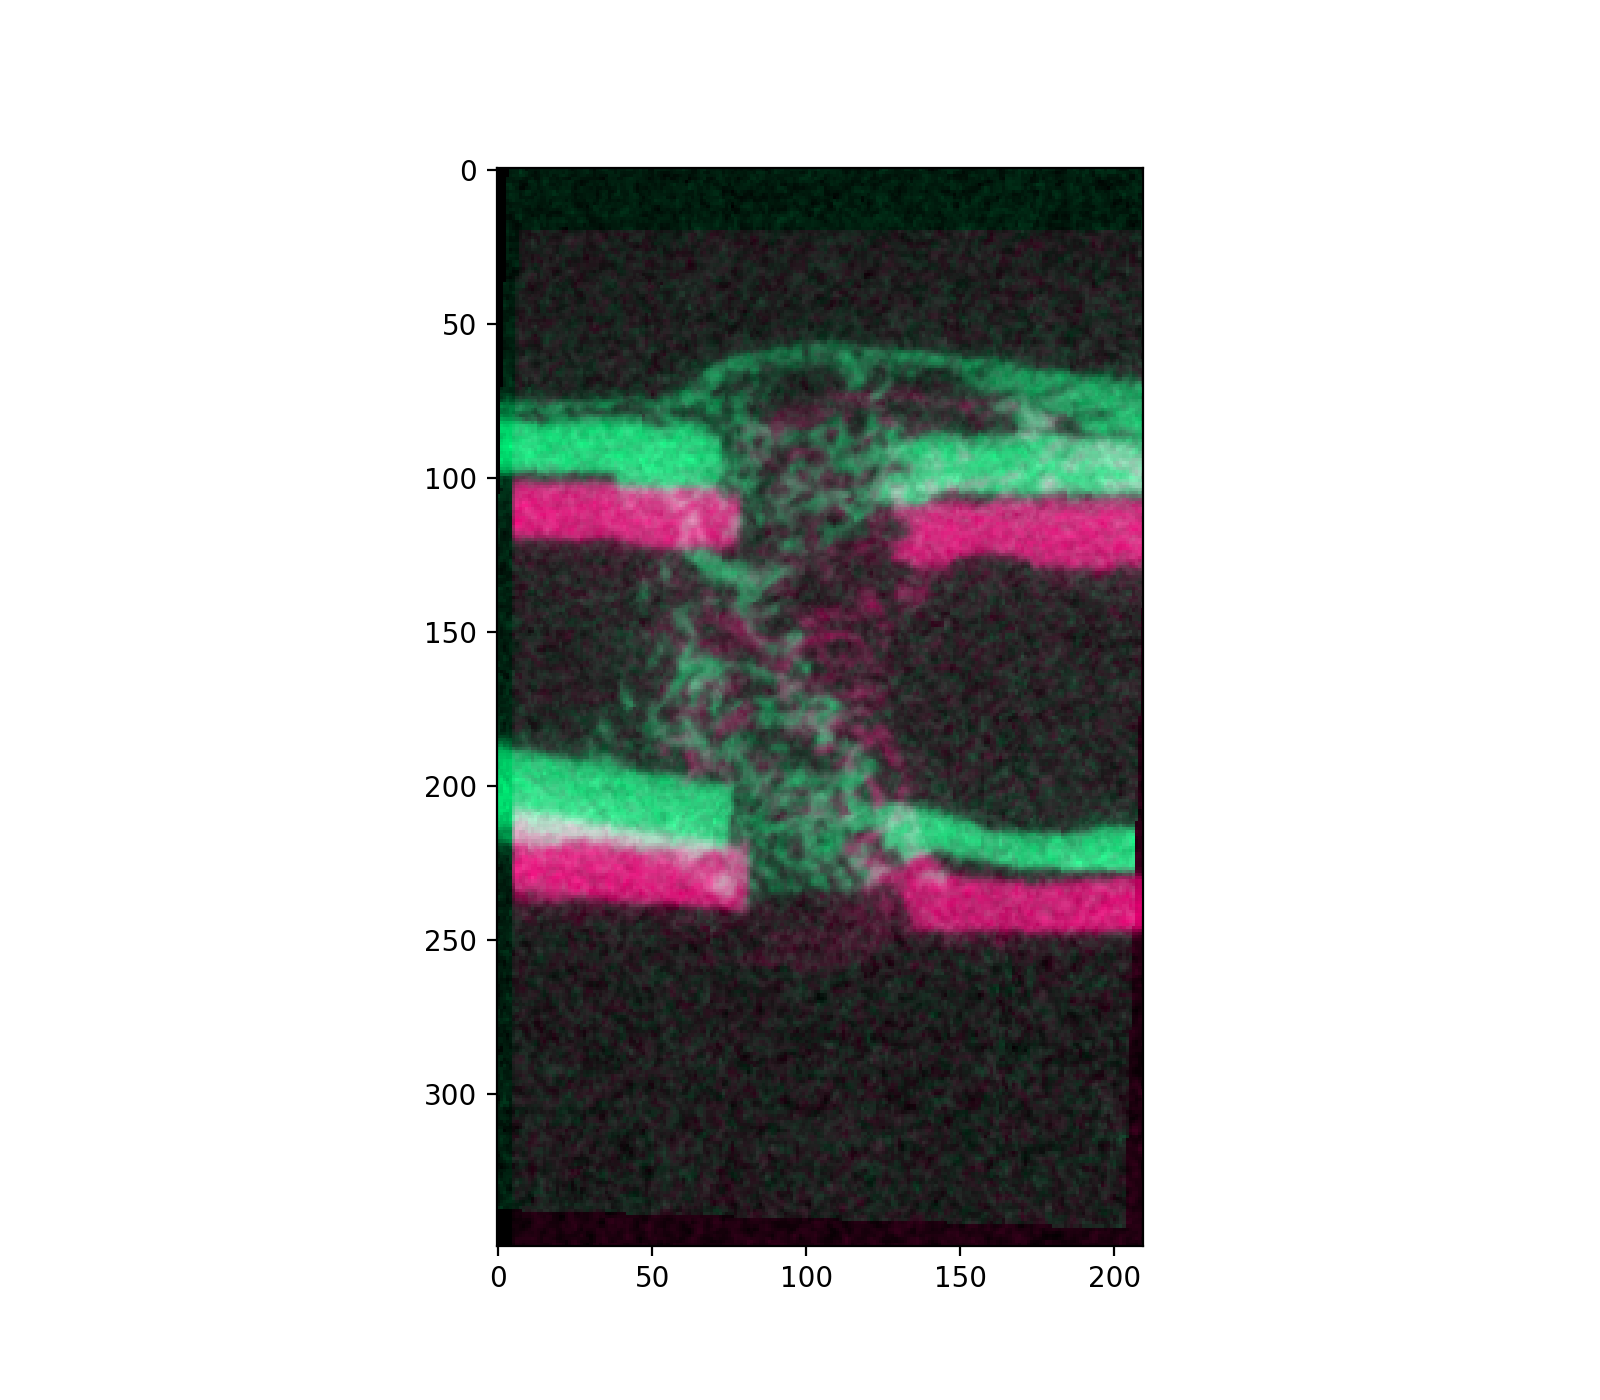

In [4]:
# puts the images into the Red(week1) and G(week2) channel of an image
overlay_RGB(images)

These images are clearly not well aligned. We will now discuss how to align the images.

## Overlaying an image

Registration involves finding the best set of transormation paramters for overlaying an image.

Run the following cell and try to find the best x,y,theta for aligning the images. 

In [5]:
# manual transform
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output, display
from scipy.ndimage import affine_transform


def move_overlay(image1, image2, dx, dy):
    T = np.identity(3)
    T[0, 2] = dy
    T[1, 2] = dx
    images = [image1, affine_transform(image2, T)]
    overlay_RGB(images)
    clear_output(True)

In [6]:
interactive(move_overlay, image1=fixed(images[0]), image2=fixed(
    images[1]), dx=(-50, 50, 0.25), dy=(-50, 50, 0.25))

interactive(children=(FloatSlider(value=0.0, description='dx', max=50.0, min=-50.0, step=0.25), FloatSlider(va…

In [7]:
class_x = [-4.5, -6.5, -5.0, -4.25, -4, -5, -4.7]
class_y = [-18.5, -22, -20.5, -20, -19, -19, -19.5]

print("Class variance in X: ", np.mean(class_x))
print("Class variance in Y: ", np.mean(class_y))

Class variance in X:  -4.8500000000000005
Class variance in Y:  -19.785714285714285


## Cost functions

We have now demonstrated the use of a powerful neural network (you) on finding the best fit. In realitiy the computer is not aware of what the images look like. The registration algorithm needs to numerically determine the goodness of fit, it can then optimize until the correct paramters are found. 

Image we have two images X and Y. The lease squared difference would be as follows:

\begin{equation*}
 C^{LS} = \sum \left( X - Y  \right)^2  
\end{equation*}

Where this is the pixel-wise sum of both images. In Python it looks like this:


```python
def least_squared(X,Y):
    delta = X-Y
    square_delta = delta**2
    return np.sum(square_delta)

```


Another meausure of similarity is the correlations function:
\begin{equation*}
 C^{cor} = \frac{\sum \left( X \cdot Y  \right) }{\sqrt{\sum X^2}.\sqrt{\sum Y^2}}
\end{equation*}

In python it looks like this:
```python 
def correlation(Image1,Image2):
    corr = np.corrcoef(Image1,y=Image2)
    return(corr[0,1])
 ```


### excercise 2:
Align the images again, this time try and use the cost function to determine your next move.


In [8]:
# abs diference cost
def least_squared(Image1, Image2):
    delta = (Image1 - Image2)
    return(np.sum(delta**2))

In [9]:
def correlation(Image1, Image2):
    return(-1*np.corrcoef(Image1.flatten(), y=Image2.flatten())[0, 1])

In [10]:
c_funs = {"correlation": correlation, "least_squared": least_squared}

In [11]:
cost = {c: [] for c in c_funs}
cost_function_names = [n for n in c_funs]


def move_overlay(image1, image2, dx, dy, cost_history, cost_function, cfuncs):
    T = np.identity(3)
    T[0, 2] = dy
    T[1, 2] = dx
    images = [image1, affine_transform(image2, T)]
    overlay_RGB_cost(images, cost_history, cost_function, cfuncs, dx, dy)
    clear_output(True)

In [12]:
interactive(move_overlay, image1=fixed(images[0]), image2=fixed(images[1]), dx=(-60, 60, 0.5), dy=(
    -60, 60, 0.5), cost_history=fixed(cost), cost_function=cost_function_names, cfuncs=fixed(c_funs))

interactive(children=(FloatSlider(value=0.0, description='dx', max=60.0, min=-60.0, step=0.5), FloatSlider(val…

In [13]:
comutational_cost = {"correlation": 0,
                     "least_squared": 0, "abs_squared_difference": 0}
for function, v in cost.items():

    for pix in v:

        comutational_cost[function] += pix[3]

print("The total pixel cost was:", comutational_cost)

The total pixel cost was: {'correlation': 73500, 'least_squared': 0, 'abs_squared_difference': 0}


This is quite an intenive task. For each movmement you made every pixel was evaluated to determine the cost function. Ideally we should align the images close so that they need less transformations. This can be done through two ways:

1. An initial guess

2. A multi-resolution scheme

A good initial guess is a holy grail in image registration, these could involve calcuating principle axes and centerms of mass. However during fracture healing the changes in the bone are large, the formation of new material can cause priciple axes to flip or swap.

A multi-resolution scheme on the other hand reduces the problem size, progressivly increasing it until the images are comapred at the native resoltuion. This system is "easy" to implement and has an inherent strength over the naive aproach.

Images contain different frequencies. In general flat areas are low frequency whilke edges (and noise) are high frequency. The lower resolution images are predominatnly low frequency information and have comparatively less noise. A pyramid approach is effectivly using a smoothed cost function, avoiding local minima, while the progressive increasing of the resolution adds high frequency correction to the solution.


In [14]:
def split_frequency(frequency, image):
    f = np.fft.fft2(image)  # forward fft
    fshift = np.fft.fftshift(f)  # shift to center frequencies
    hff = np.copy(fshift)
    origin = np.array(hff.shape)*0.5
    y, x = np.ogrid[-origin[0]:origin[0], -origin[1]:origin[1]]
    mask = x*x + y*y <= frequency*frequency  # mask for high and low pass filtering
    hff[mask] = 0  # high pass filter
    lff = np.copy(fshift)
    lff[mask != 1] = 0  # low pass filter
    hff_ishift = np.fft.ifftshift(hff)  # inverse shift
    lff_ishift = np.fft.ifftshift(lff)  # inverse shift
    lff_back = np.fft.ifft2(lff_ishift)  # inverse fft
    hff_back = np.fft.ifft2(hff_ishift)  # inverse fft
    hff_back = np.abs(hff_back)
    lff_back = np.abs(lff_back)
    # contrast adjustment for viewing image
    hff_back /= np.percentile(hff_back, 99)
    hff_back[hff_back > 1] = 1.0

    horizontal_pane([image, (lff_back), hff_back])

In [15]:
interactive(split_frequency, frequency=(0, 204, 1), image=fixed(images[0]))

interactive(children=(IntSlider(value=102, description='frequency', max=204), Output()), _dom_classes=('widget…

## Pyrmaid registration

- Frequencies are dependent on the image resolution
- Easiest way to create a pyramid is to create a stack of rescaled images

In [16]:
# manual transform

from scipy.ndimage.interpolation import zoom


cost_pyramid = {c: [] for c in c_funs}


def move_overlay_pyramid(image1, image2, dx, dy, cost_history, cost_function, cfuncs, level, history):
    level = int(level)
    level = 2**(level-1)
    if level != 1:
        i1 = zoom(image1, 1/level, order=0)
        i2 = zoom(image2, 1/level, order=0)
    else:
        i1 = image1
        i2 = image2
    T = np.identity(3)
    T[0, 2] = dy*1/level
    T[1, 2] = dx*1/level
    if level != 1:
        images = [i1, affine_transform(i2, T, order=0)]
    else:
        images = [i1, affine_transform(i2, T)]
    if len(cost_history)>0:
        overlay_RGB_cost(images, cost_history, cost_function,
                     cfuncs, dx, dy, history)
    else:
        print('Move around to make some history')
    clear_output(True)

In [17]:
interactive(move_overlay_pyramid, image1=fixed(images[0]), image2=fixed(images[1]), dx=(-60, 60, 0.5), dy=(-60, 60, 0.5), cost_history=fixed(
    cost_pyramid), cost_function=cost_function_names, cfuncs=fixed(c_funs), level=[5, 4, 3, 2, 1], history=[None, 10, 20, 100])

interactive(children=(FloatSlider(value=0.0, description='dx', max=60.0, min=-60.0, step=0.5), FloatSlider(val…

In [18]:
comutational_cost_pyramid = {"correlation": 0, "least_squared": 0}
for function, v in cost_pyramid.items():

    for pix in v:

        comutational_cost_pyramid[function] += pix[3]

print("The total pixel cost was:", comutational_cost_pyramid)

The total pixel cost was: {'correlation': 286, 'least_squared': 0}


# Automated registration

This is cleary a difficult problem to do by hand. As we have these functions it should be easy to minimise them. Actualy there is a whole field of mathematics and computer science devoted towards this: Optimisation. It is not really "easy" to do.

There are several course at the ETH which can give actually useful information on this:
- 401-0647-00L  Introduction to Mathematical Optimization
- 227-0707-00L  Optimization Methods for Engineers (good for Graeme)
- 261-5110-00L  Optimization for Data Science (Machine learning)
- 401-3904-00L  Convex Optimization (Applied to specific problems where the only minima is the global minimum)

In the bellow example the registration is performed using a [Evolutionary Algorithm](https://en.wikipedia.org/wiki/Evolutionary_algorithm). Simply put a random population of initial guesses are used, the cost function is determined for each and only the fittest X% are mated to create a new set of guesses.

To avoid being captured in local minima *mutations* are introduced, which introduce new paramters values to the increasingly homogenus population.

In [19]:
# opitimizer with least squared

from scipy.optimize import minimize as ls
from scipy.optimize import differential_evolution


def correlation(x, i1, i2, path):
    x = np.array(x)
    T = np.identity(3)
    T[0, 2] = x[1]
    T[1, 2] = x[0]
    images = [i1.flatten(), affine_transform(i2, T).flatten()]
    delta = -1*np.corrcoef(images[0], y=images[1])[0, 1]
    path.append((x[0], x[1], delta))
    return(delta)


def least_squared(x, i1, i2, path):
    x = np.array(x)
    T = np.identity(3)
    T[0, 2] = x[1]
    T[1, 2] = x[0]
    images = [i1, affine_transform(i2, T)]
    delta = np.sum((images[0]-images[1])**2)
    path.append((x[0], x[1], delta))
    return(delta)


path_corralation = []
optimum_c = differential_evolution(correlation, [(-60, 30), (-60, 30)], args=(
    images[0], images[1], path_corralation), tol=0.00125)  # ,method='Powell',options={'eps':0.5})

path_least_squared = []
optimum_ls = differential_evolution(least_squared, [(-60, 30), (-60, 30)], args=(
    images[0], images[1], path_least_squared), tol=0.00125)  # ,method='Powell',options={'eps':0.5})

/srv/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: overflow encountered in ulong_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


We have now searched for the best transform using both cost functions. What do they look like?

<IPython.core.display.Javascript object>


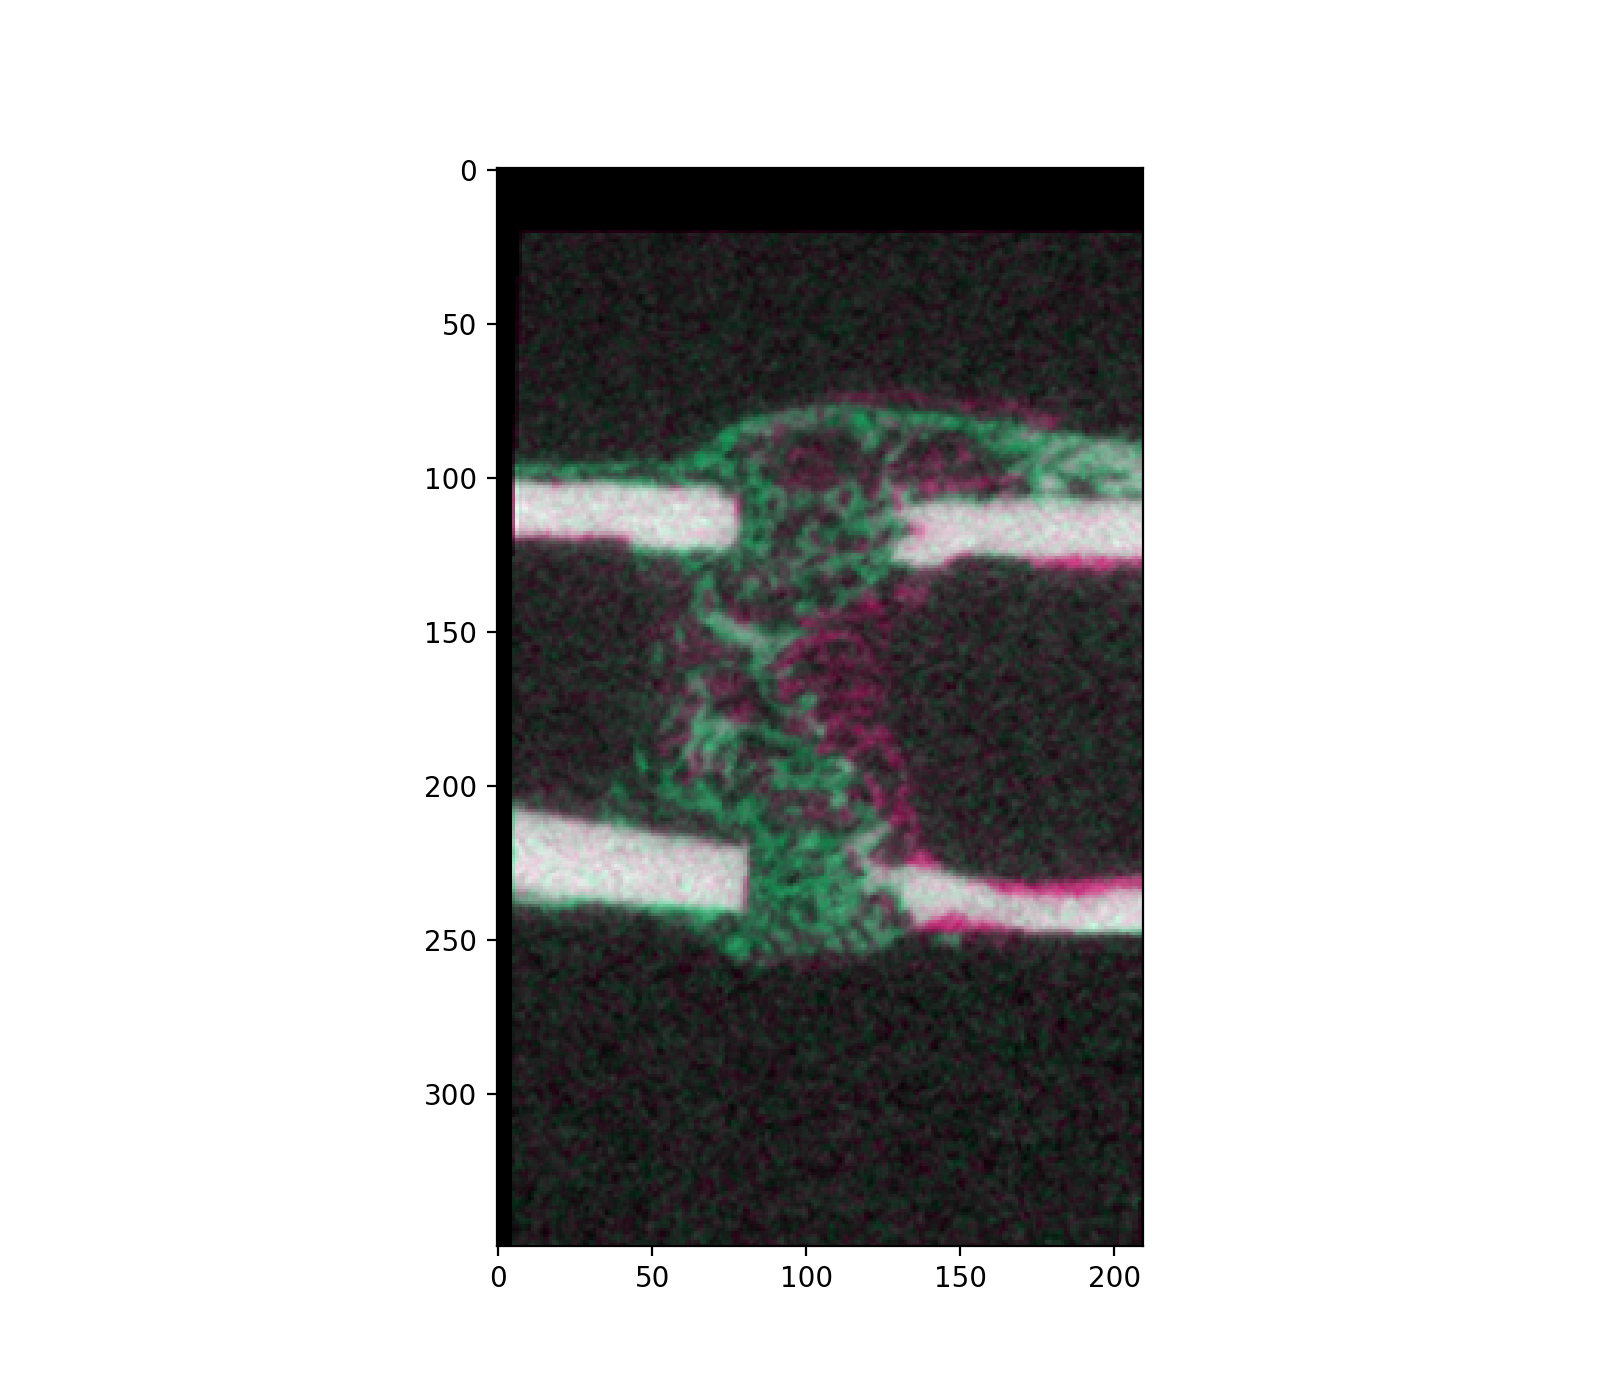

In [20]:
# Using the correlation cost function

x = optimum_c['x']
T = np.identity(3)
T[0, 2] = x[1]
T[1, 2] = x[0]
overlay_RGB([images[0], affine_transform(images[1], T)])

<IPython.core.display.Javascript object>


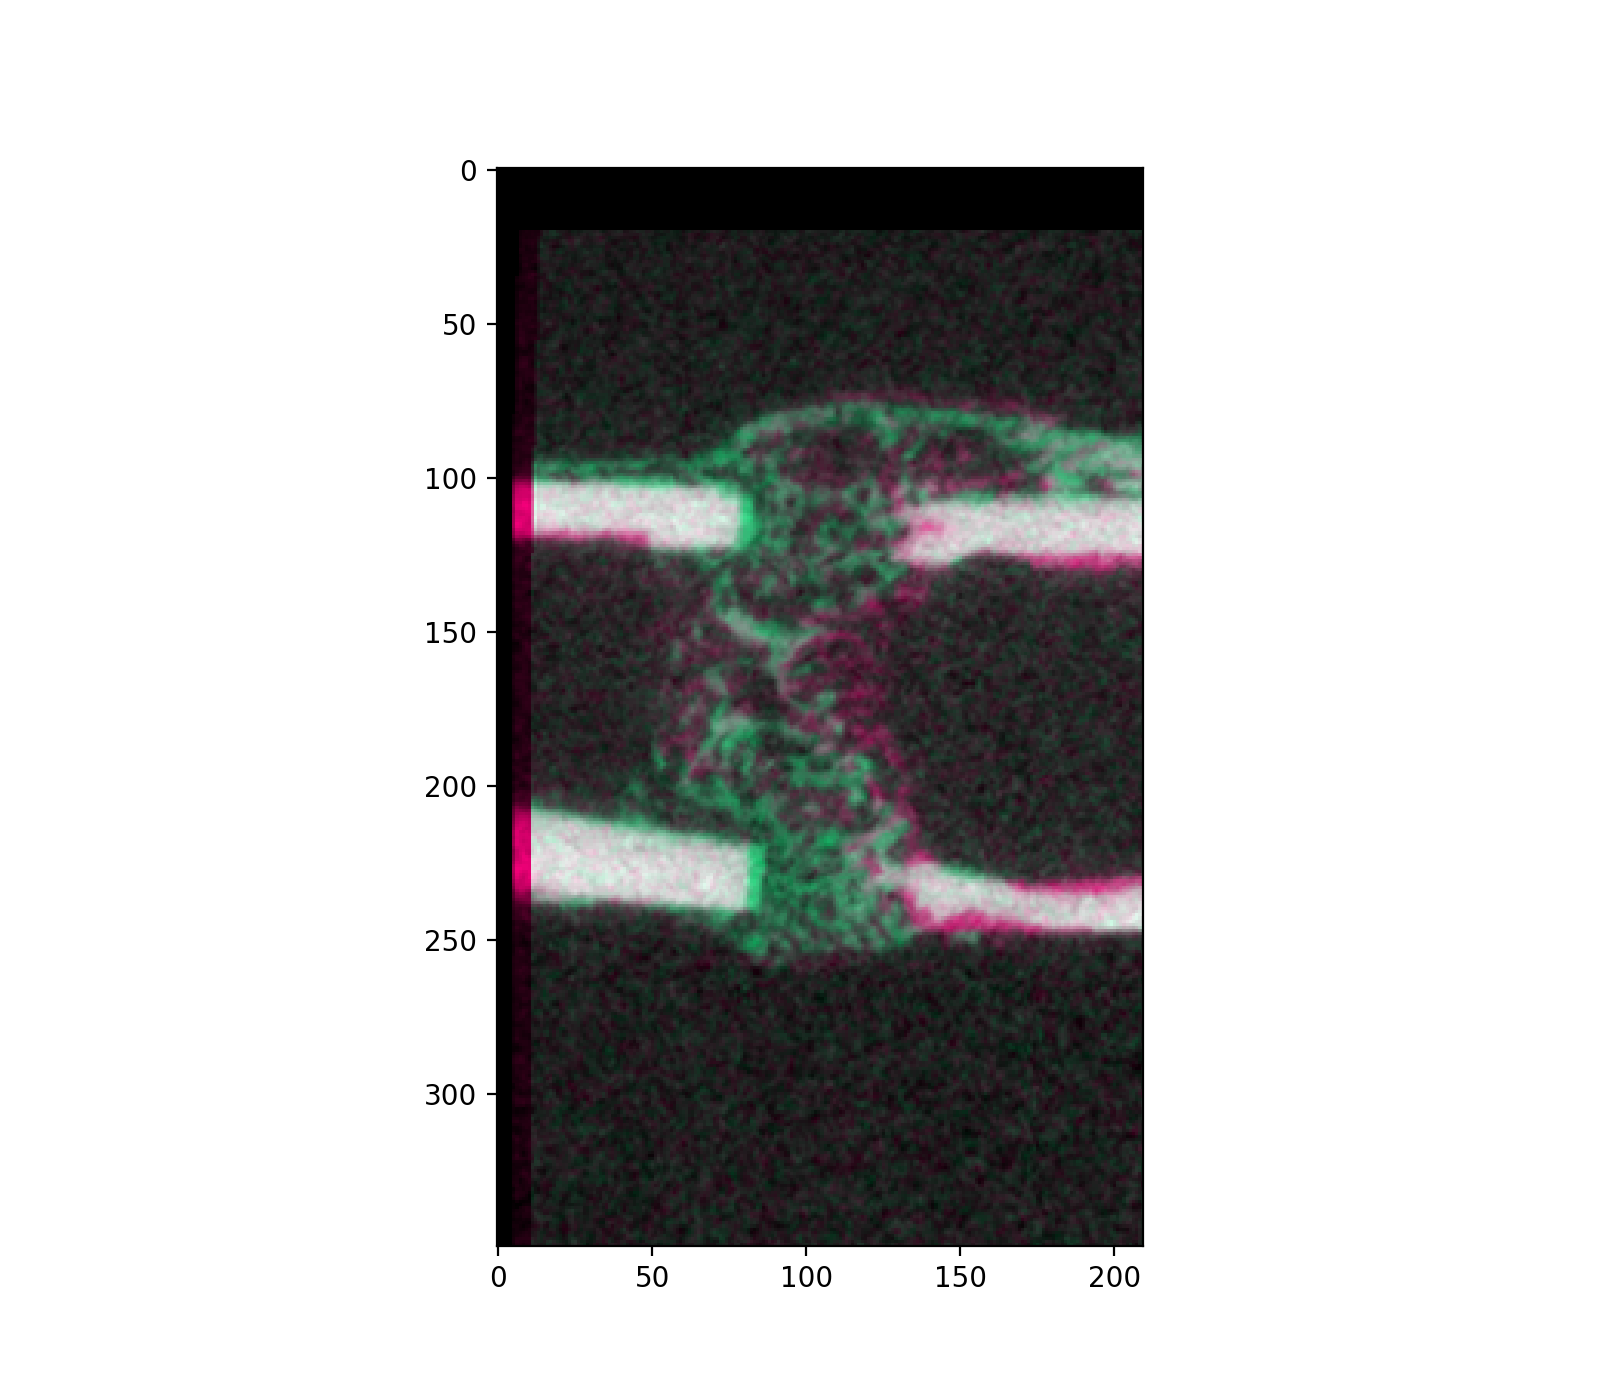

In [21]:
# Using the Least squared cost function
x = optimum_ls['x']
T = np.identity(3)
T[0, 2] = x[1]
T[1, 2] = x[0]
overlay_RGB([images[0], affine_transform(images[1], T)])

<IPython.core.display.Javascript object>


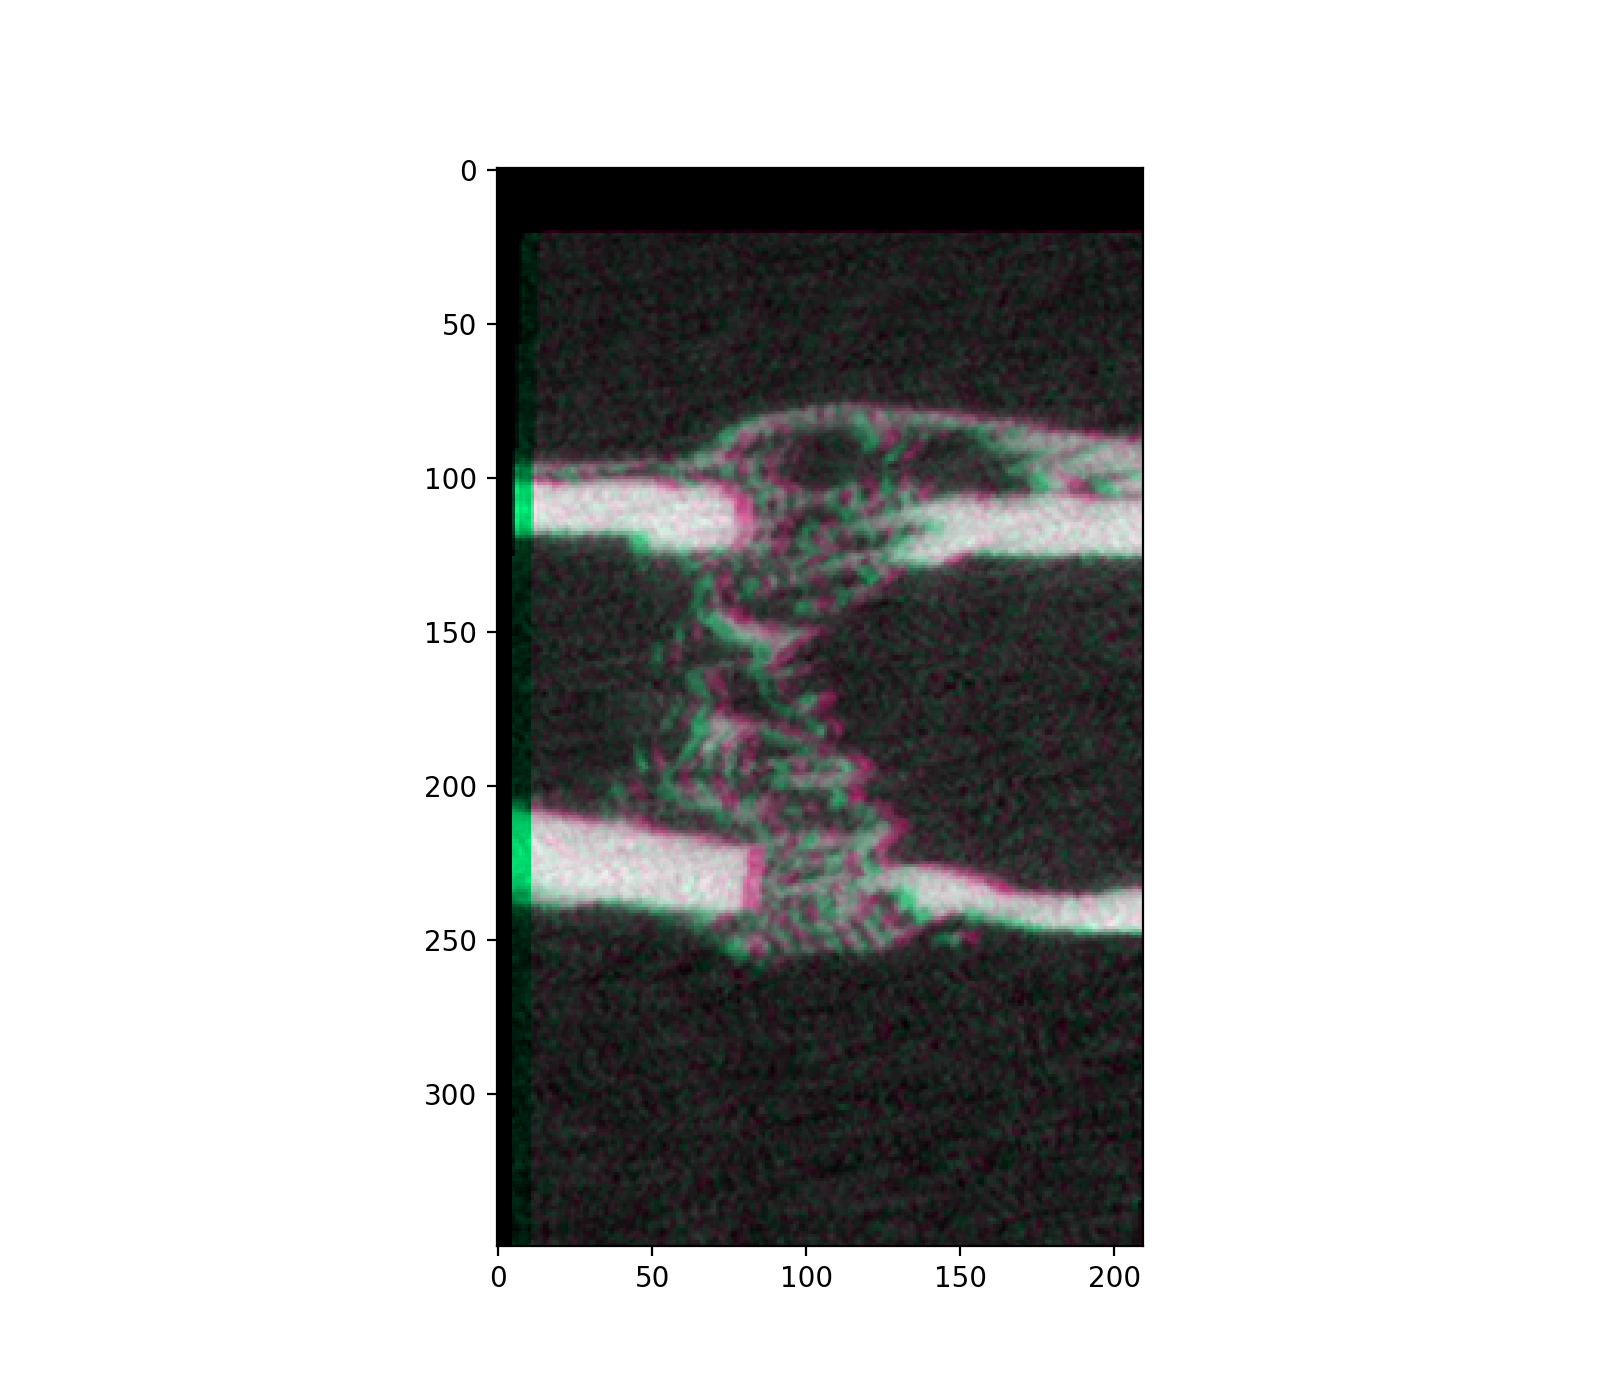

In [22]:
# difference in the images
diff = []
x = optimum_ls['x']
T = np.identity(3)
T[0, 2] = x[1]
T[1, 2] = x[0]
diff.append(affine_transform(images[1], T))
x = optimum_c['x']
T = np.identity(3)
T[0, 2] = x[1]
T[1, 2] = x[0]
diff.append(affine_transform(images[1], T))
overlay_RGB(diff)

In [23]:
print("Difference in the transformation", optimum_ls['x']-optimum_c['x'])

Difference in the transformation [-5.94442877  0.8700855 ]


In the cell bellow the cost functions are plotted. This can be done as the optimization we used search an entire range of parameters.


<IPython.core.display.Javascript object>


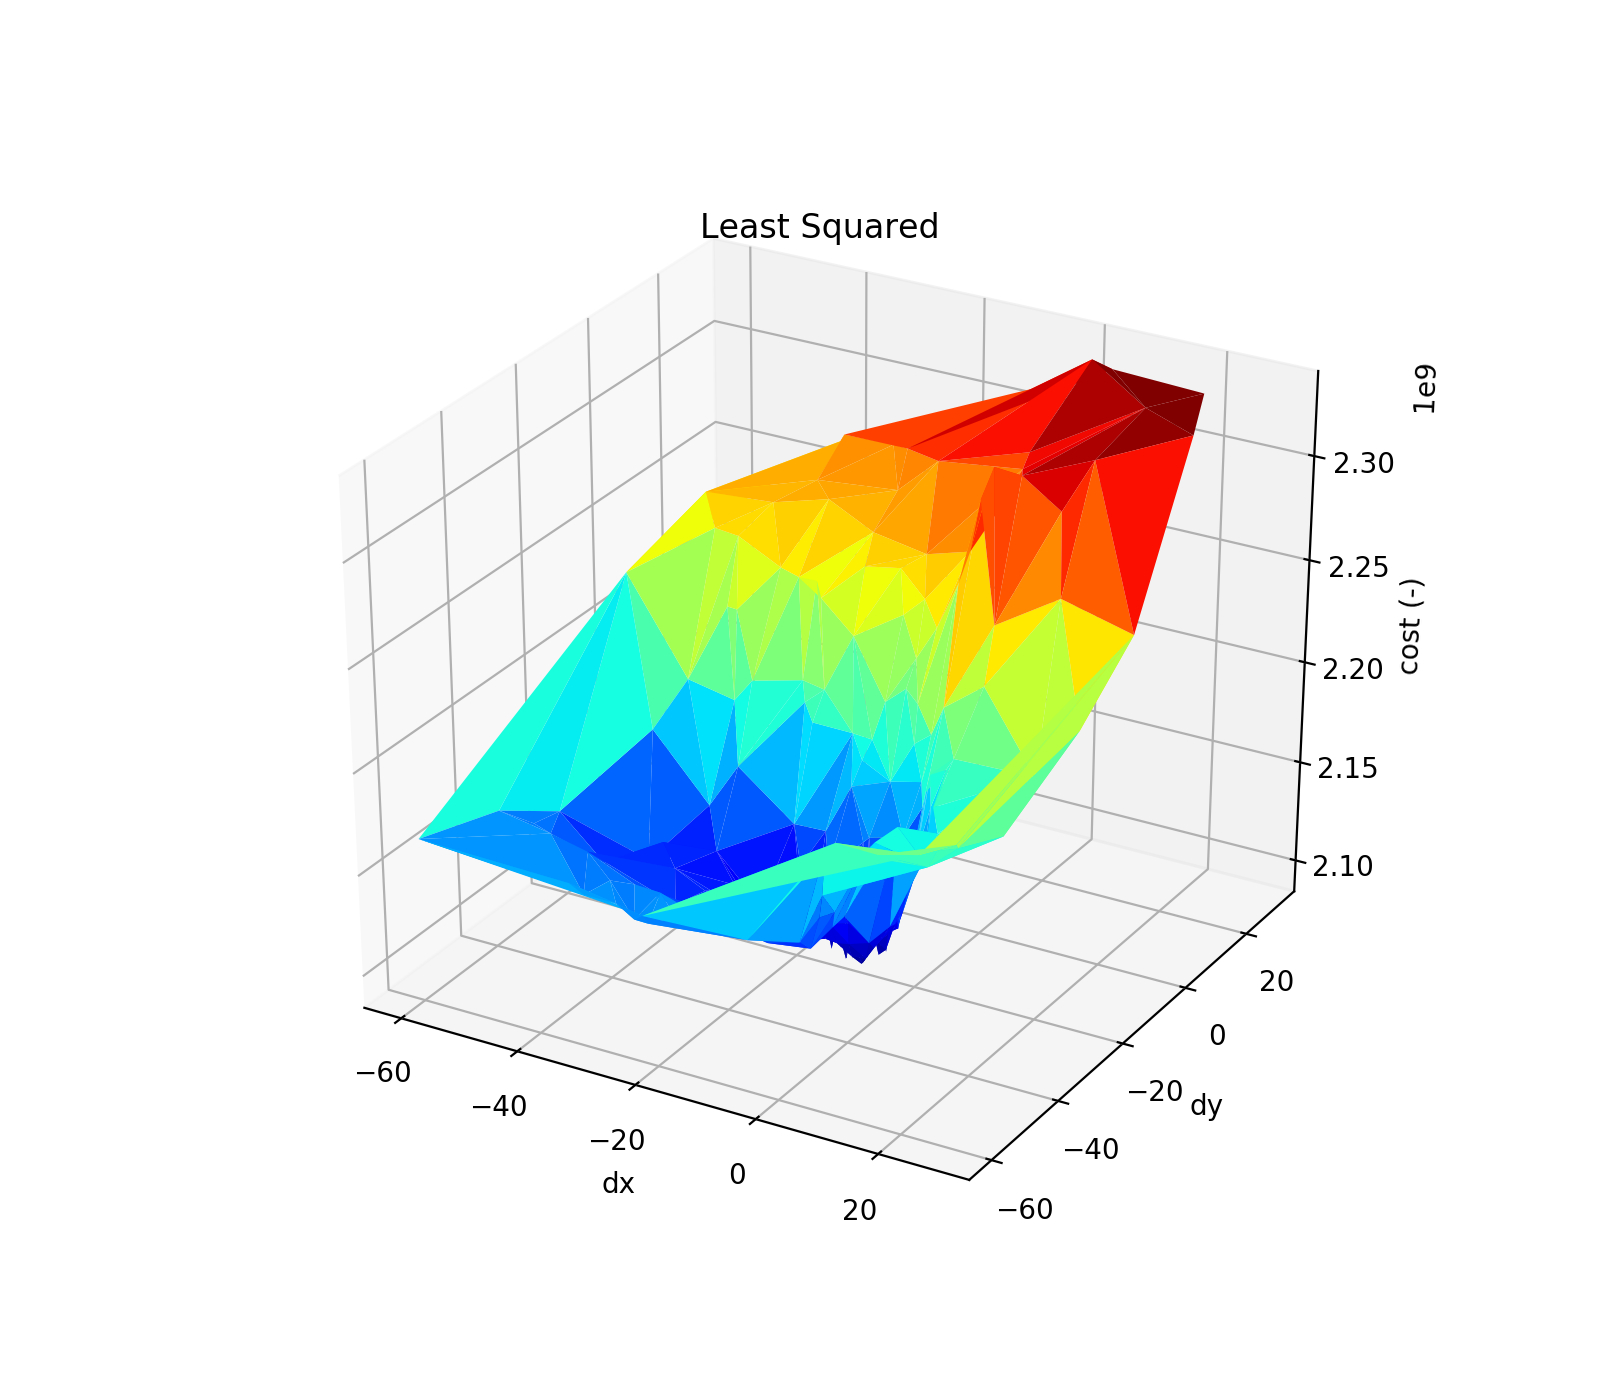

In [24]:
p_c = np.array(path_corralation)
p_ls = np.array(path_least_squared)


import matplotlib.tri as mtri
fig = plt.figure()
matplotlib.rcParams['figure.figsize'] = (9, 10)
'''
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(p_c[:,0],p_c[:,1],p_c[:,2],cmap=plt.cm.jet)
ax.set_title("Correlation")
ax.set_xlabel("dx")
ax.set_ylabel("dy")
ax.set_zlabel("cost (-)")
'''

ax = fig.add_subplot(111, projection='3d')
ax.set_title("Least Squared")
ax.set_xlabel("dx")
ax.set_ylabel("dy")
ax.set_zlabel("cost (-)")
ax.plot_trisurf(p_ls[:, 0], p_ls[:, 1], p_ls[:, 2], cmap=plt.cm.jet)

# Conclusion to part 1

- Image registration is not black magic
    - It is repetitive but simple maths
- Algorithms are fallible:
    - Local minima in solution
    - Orientation of images
    - Qualitiy of images
- Understanding your chosen cost function crucial for:
    - Choosing an algorithm
    - Knowing if your data is sufficient